# (Efficient) Spherical Harmonic Transform

## Preliminaries

### Spherical harmonics transform

The truncated series expansion of a function $f$ defined on the surface of a sphere can be written as

$$
f(\theta, \lambda) = \sum_{m=-M}^{M} \exp(im\lambda) \sum_{n=|m|}^{M} F_n^m \bar{P}_n^m (\cos \theta),
$$

where $\theta$ is the colatitude, $\lambda$ the longitude, $\bar{P}_n^m$ the normalized, associated Legendre polynomials and $F_n^m$, the expansion coefficient associated to the mode $(m,n)$.

A direct spherical harmonic transform can be accomplished by a Fourier transform

$$
F^m(\theta) = \frac{1}{2 \pi} \int_{0}^{2\pi} f(\theta, \lambda) \exp(-im\lambda) \; \mathrm{d}\lambda
$$

in longitude and a Legendre transform

$$
F_n^m = \frac{1}{2} \int_{-1}^1 F^m(\theta) \bar{P}_n^m(\cos \theta) \; \mathrm{d} \cos \theta
$$

in latitude.

## Usage

### Preparation

Let us begin by loading some libraries that we will be needing:

In [ ]:
import h5py

f = h5py.File("/d0/amunozj/AFT/2022/12/AFTmap_20221221_1200.h5", 'r')

# f['maps']['aftmap'][...]
data = nn.functional.interpolate(torch.from_numpy(f['maps']['aftmap'][...]).unsqueeze(0).unsqueeze(0), size=(512,1024)).squeeze()
data.shape

In [84]:
import torch
import torch.nn as nn
import torch.fft as fft
import numpy as np
import matplotlib.pyplot as plt
from sunpy.visualization.colormaps import cm

import sys
sys.path.append("../")

cmap = 'hmimag'

We should also load the `torch-sht`:

In [85]:
from torch_harmonics import *

If a GPU is available we want to use it:

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Test data

Let us load some test-data in 2D for testing. We use the MOLA digital elevation map of MARS, courtesy of NASA:

In [87]:
!wget https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg -O /home/amunozj/git_repos/aft-fno/mola_topo.jpg

--2023-12-11 17:35:32--  https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg
Resolving astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)... 137.227.239.81, 2001:49c8:c000:122d::81
Connecting to astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)|137.227.239.81|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 55192 (54K) [image/jpeg]
Saving to: ‘/home/amunozj/git_repos/aft-fno/mola_topo.jpg’

/home/amunozj/git_r 100%[===================>]  53.90K  --.-KB/s    in 0.08s   

2023-12-11 17:35:32 (675 KB/s) - ‘/home/amunozj/git_repos/aft-fno/mola_topo.jpg’ saved [55192/55192]



Let us load and visualize the data:

In [89]:
# import imageio.v3 as iio

# img = iio.imread('/home/amunozj/git_repos/aft-fno/mola_topo.jpg')
# #convert to grayscale
# data = np.dot(img[...,:3]/255, [0.299, 0.587, 0.114])
# # interpolate onto 512x1024 grid:
# data = nn.functional.interpolate(torch.from_numpy(data).unsqueeze(0).unsqueeze(0), size=(512,1024)).squeeze()
# data.shape

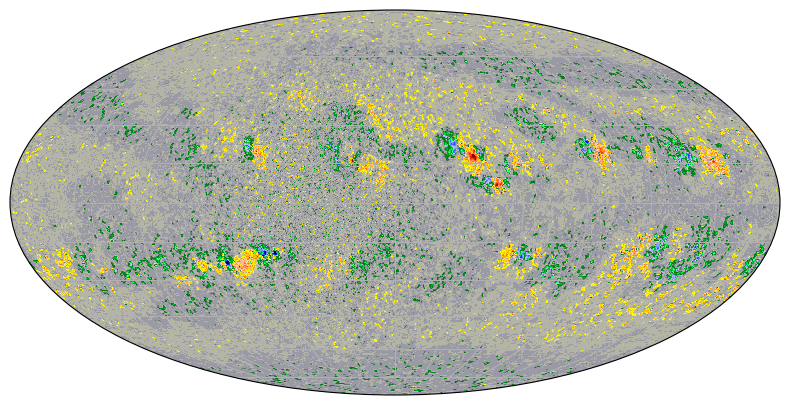

In [90]:
vmax = 1000

n_theta = data.shape[0]
n_lambda = data.shape[1]
lon = np.linspace(-np.pi, np.pi, n_lambda)
lat = np.linspace(np.pi/2., -np.pi/2., n_theta)
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
ax.pcolormesh(Lon, Lat, data, cmap=cmap, vmin=-vmax, vmax=vmax)
# ax.set_title("Elevation map of mars")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

We want the data on the GPU. Moreover, `torch_harmonics` expects the last two dimensions to be the spatial dimensions. To this end, we permute the data:

In [91]:
signal = data.to(device)

### Spherical Harmonic Transform:

To allow for composability, `torch_harmonics` provides it's transform in the form of PyTorch NN modules. As such we begin by initializing them:

In [92]:
sht = RealSHT(n_theta, n_lambda, grid="equiangular").to(device)
isht = InverseRealSHT(n_theta, n_lambda, grid="equiangular").to(device)

In [93]:
coeffs = sht(signal)

Let us plot the logarithm of the absolute coefficients:

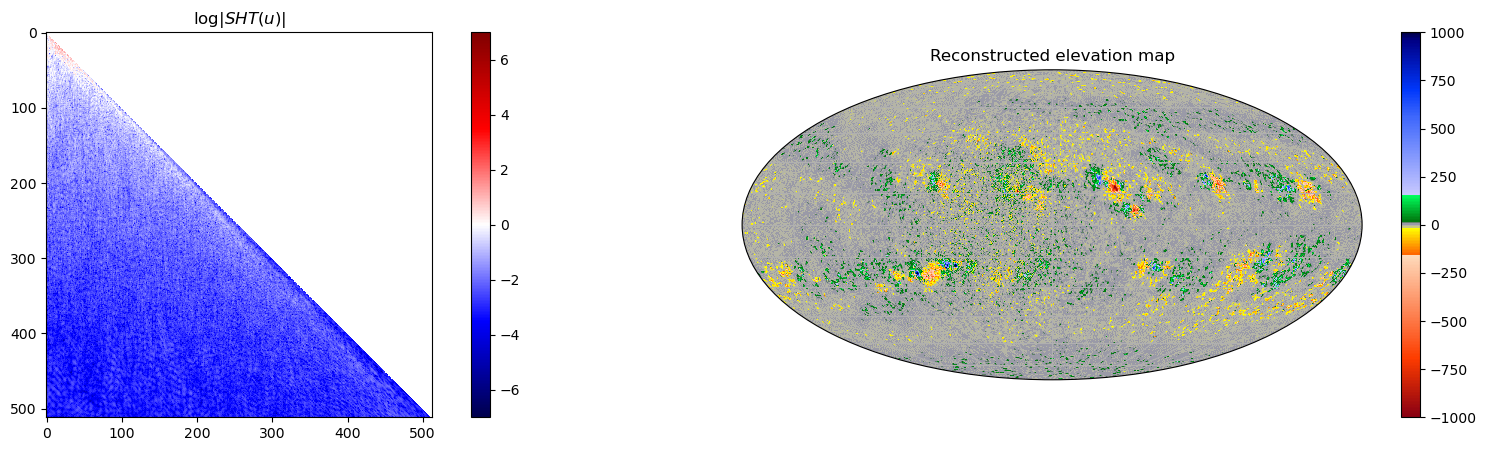

In [94]:
fig = plt.figure(figsize=(22, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(coeffs.abs().log().cpu(), cmap='seismic', vmin=-7, vmax=7)
plt.title("$\log | SHT(u) |$")
plt.colorbar()

ax = fig.add_subplot(1, 2, 2, projection='mollweide')
plt.pcolormesh(Lon, Lat, isht(coeffs).cpu(), cmap=cmap, vmin=-vmax, vmax=vmax)
ax.set_title("Reconstructed elevation map")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
plt.show()

We can transform the the solution back and plot the error:

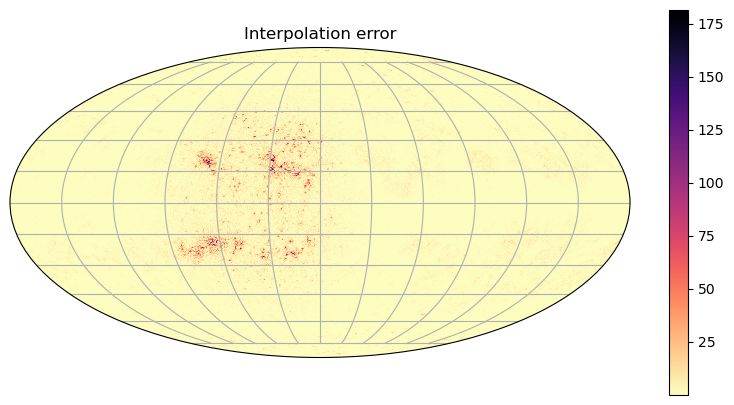

In [95]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
img = ax.pcolormesh(Lon, Lat, (isht(coeffs).cpu() - data).abs(), cmap='magma_r')
ax.set_title("Interpolation error")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar(img, ax=ax)
plt.show()

### Differentiability

`torch_harmonics` is differentiable, so let's use this functionality. We can perform a simple fit of spectral coefficients by using a simple model which will use 100 modes to approximate our original model:

In [96]:
class SpectralModel(nn.Module):
    def __init__(self, n_modes, out_dims):
        super().__init__()
        self.coeffs = nn.Parameter(torch.randn(n_modes, n_modes+1, dtype=torch.complex128))
        self.isht = InverseRealSHT(out_dims[0], out_dims[1], lmax=n_modes, mmax=n_modes+1, grid="equiangular").to(device)

    def forward(self):
        return self.isht(self.coeffs)

sh_model = SpectralModel(400, (n_theta, n_lambda)).to(device)
sh_model

SpectralModel(
  (isht): InverseRealSHT(
    nlat=512, nlon=1024,
     lmax=400, mmax=401,
     grid=equiangular, csphase=True
  )
)

and now, let us train the model

In [97]:
optimizer = torch.optim.Adam(sh_model.parameters(), lr = 5e-2)

for iter in range(500):

    loss = (sh_model() - signal).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 10 == 0:
        print(f'iteration: {iter} loss: {loss.item()}')

iteration: 0 loss: 13694.699236902386
iteration: 10 loss: 4251.088509623882
iteration: 20 loss: 1500.8467919038526
iteration: 30 loss: 612.6067490020241
iteration: 40 loss: 292.8638153506642
iteration: 50 loss: 165.05931819238828
iteration: 60 loss: 109.69825635731317
iteration: 70 loss: 83.79582432428987
iteration: 80 loss: 70.42618221670938
iteration: 90 loss: 62.79041284935059
iteration: 100 loss: 58.017547071262186
iteration: 110 loss: 54.826765763577455
iteration: 120 loss: 52.6030247931438
iteration: 130 loss: 51.01477561157016
iteration: 140 loss: 49.86606281960351
iteration: 150 loss: 49.030994242771314
iteration: 160 loss: 48.42360963482618
iteration: 170 loss: 47.982657672823585
iteration: 180 loss: 47.66367397278161
iteration: 190 loss: 47.43390157380333
iteration: 200 loss: 47.269138786206845
iteration: 210 loss: 47.15157135459124
iteration: 220 loss: 47.06814404272572
iteration: 230 loss: 47.009090990160956
iteration: 240 loss: 46.96763694673474
iteration: 250 loss: 46.938

let us plot the approximation:

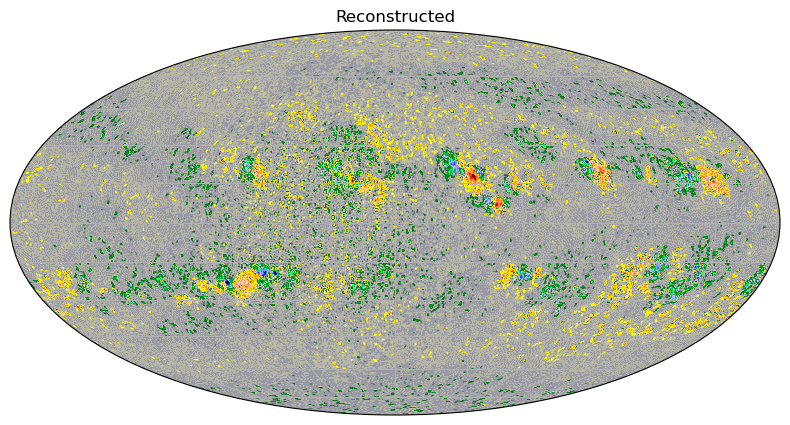

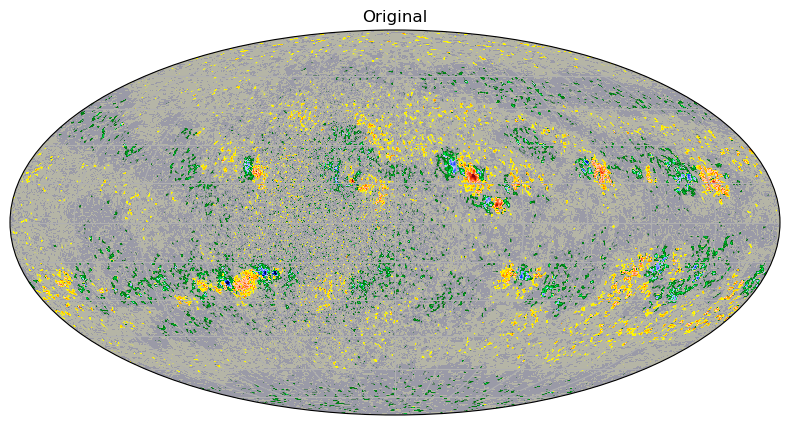

In [101]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
ax.pcolormesh(Lon, Lat, sh_model().detach().cpu(), cmap=cmap, vmin=-vmax, vmax=vmax)
# ax.set_title("Elevation map of mars")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Reconstructed')
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
ax.pcolormesh(Lon, Lat, data, cmap=cmap, vmin=-vmax, vmax=vmax)
# ax.set_title("Elevation map of mars")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('Original')
plt.show()

Not bad! Let us again plot the error:

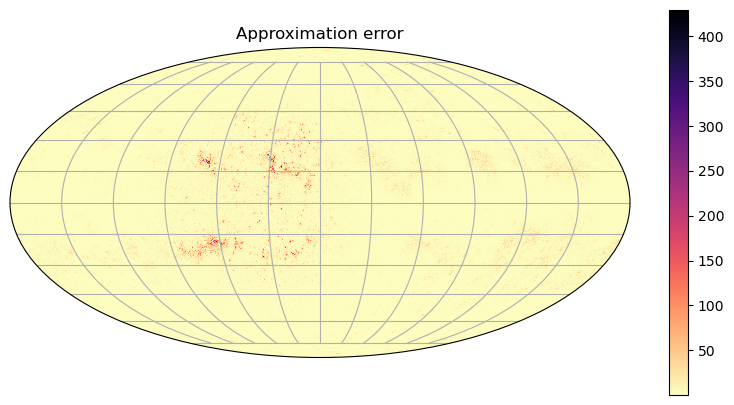

In [99]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
img = ax.pcolormesh(Lon, Lat, (sh_model().detach() - signal).abs().cpu(), cmap='magma_r')
ax.set_title("Approximation error")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar(img, ax=ax)
plt.show()

## Conclusion

This concludes our introduction to `torch-harmonics`. If you are enjoying this library, make sure to cite us: